In [43]:
!pip install -q sentence_transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
import pandas as pd 
import os
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
# Load data
DATA_PATH = "/kaggle/input/eedi-mining-misconceptions-in-mathematics"
train = pd.read_csv(DATA_PATH+"/train.csv")
mis_map = pd.read_csv(DATA_PATH+"/misconception_mapping.csv")

In [3]:
#  misconceptions are tagged to which subject and/or construct
train_eda_answer_long = train.melt(id_vars=['QuestionId','ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'QuestionText', 'CorrectAnswer'],
                            value_vars=['AnswerAText','AnswerBText', 'AnswerCText', 'AnswerDText'],
                           var_name="Answer",
                           value_name="AnswerText")


train_eda_misconception_long = train.melt(id_vars=['QuestionId','ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'QuestionText', 'CorrectAnswer'],
                            value_vars=['MisconceptionAId','MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId'],
                           var_name="Misconception",
                           value_name="MisconceptionId")
train_eda_long = train_eda_answer_long.copy()
train_eda_long['MisconceptionId'] = train_eda_misconception_long['MisconceptionId']
train_eda_long=train_eda_long.sort_values(['QuestionId'])

# Pulling in the misconception
"""
There are 1,237 unlabelled misconceptions, and 4,370 labelled ones
"""
train_eda_long['AnswerOption'] = train_eda_long['Answer'].str[6:7]
train_misconceptions = train_eda_long[train_eda_long['AnswerOption'] != train_eda_long['CorrectAnswer']].copy().reset_index(drop=True).drop(columns=['Answer'])
train_misconceptions = train_misconceptions.merge(mis_map, how='left', on='MisconceptionId')
train_misconceptions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607 entries, 0 to 5606
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   QuestionId         5607 non-null   int64  
 1   ConstructId        5607 non-null   int64  
 2   ConstructName      5607 non-null   object 
 3   SubjectId          5607 non-null   int64  
 4   SubjectName        5607 non-null   object 
 5   QuestionText       5607 non-null   object 
 6   CorrectAnswer      5607 non-null   object 
 7   AnswerText         5607 non-null   object 
 8   MisconceptionId    4370 non-null   float64
 9   AnswerOption       5607 non-null   object 
 10  MisconceptionName  4370 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 482.0+ KB


In [56]:
# For misconceptions: Sequence of final classification to be determined by most specific topics to most general topics based on the heatmap 
# of misconception topics vs question topics

data_analysis_probability_regex = "frequency table|frequenc|interquartile|percentile|range|probability|mutually exclusive|sets|bar chart|pie chart|sampl|population|correlation|intersection|union|histogram|venn|\Wmean\W|\Wmode\W|median|averag|outlier|statistic|stem and leaf|pictogram"
seq_pattern_nth_regex = "sequence|linear pattern|\Wnth\W|triangle number"
trig_regex = "\Wsin\W|\Wcos\W|\Wtan\W|sine|cosine|\strigonomet|sohcahtoa"
basic_geometry_angles_regex = "geometry|angle|similarity scale|scale factor|shapes|congruen|3D|2D|symmetry|parallel|perpendicular|degrees|acute|obtuse|Pythagoras|chord|prism|midpoint|sector|polygon|hexagon|pentagon|octagon|shape|diameter|radius|bearing|plane|segment|arc|cuboid|cone|sphere|prism|pyramid|rhombus|vertices|faces|\Wedges|clockwise|\Wnorth\W|\Wsouth\W|\Wwest\W|\Weast\W"
geometry_mensuration_regex = "perimeter|area|volume|circumference" # Length overlaps with units
graphs_regex = "graph|area under.*graph|rate of change|gradient|vector|axis|axes|coordinate|rotat|distance|reflect|mirror|\Worigin\W|translate|points|line of symmetry"
algebra_functions_regex = "algebra|bar model|equation|variable|intercept|mx|function|coefficient|quadratic|expression|substitut|identity"
factorisation_and_expansion_regex = "factoris|expan|complet.*square|hcf|lcf|highest common|lowest common|common factor"
numberforms_regex = "decimal|proportion|ratio|percentage|fraction|inverse|reciprocal|number line|number|digit|prime|\d\/\d|\d\.\d|\d%|denominator|numerator|billions|millions|thousands|hundreds|tens|tenth|hundredth|thousandth|millionth"
roots_and_power_regex = "surd|root|power|cube|square|cubic|cubing|squaring|indice"
units_regex = "mg|\dg|kg|gram|\dcl|ml|\dl|litre|\dmm|cm|\dm|km|metre|mile|mass|weight|temperature|celcius|fahrenheit|money|cash|£|¢"
operations_regex = "add|\Wsum\W|subtract|difference|multipl|divid|division|operation|timestable|napier|commutative|associative"
time_regex = "hour|minute|seconds|week|day|month|year|decade|\WAM\W|\WPM\W|\Wclock\W|timetable|time\W|speed|duration"
round_regex = "\Wround|rounds|significant figure|s\.?f\.?"
pos_neg_regex = "positive|negative|absolute"
inequality_regex = "inequalit|<|>|≥|≤"
misc_regex = "\Wroman\W|estimated when not appropriate|objective|subjective"

regex_test = "factor" # object after transformations
print(mis_map['MisconceptionName'].str.contains(regex_test,regex=True, case=False).sum())
mis_map[mis_map['MisconceptionName'].str.contains(regex_test,regex=True, case=False)]['MisconceptionName'].to_list()


128


['Thinks a quadratic without a non variable term, can not be factorised',
 'Does not realise that division can be broken down into factors',
 'Cannot identify a common factor when simplifying algebraic fractions',
 'When asked for factors of an algebraic expression, thinks any part of a term will be a factor',
 'Does not think a factorised expression is equivalent to its multiplied out form',
 'Thinks a factor of the final digit is also a factor of the whole number',
 'Does not think a number can be a factor of itself',
 'Does not recognise factorising a quadratic',
 'Believes the smallest number in a set of numbers is always their highest common factor',
 'Identifies a common factor but not the highest common factor',
 'When finding a missing number in a factor tree, multiplies by the factor given rather than dividing.',
 'Believes the intersection in a prime factor venn diagram does not contribute to the size of the number represented by a circle ',
 'Subtracted rather than divided b

In [52]:
# Manually check what has not been classified yet
regex_list = [data_analysis_probability_regex, seq_pattern_nth_regex, trig_regex,
              basic_geometry_angles_regex, geometry_mensuration_regex, graphs_regex,
              algebra_functions_regex, factorisation_and_expansion_regex,
              numberforms_regex, roots_and_power_regex, round_regex, pos_neg_regex,
              units_regex, operations_regex, time_regex, inequality_regex, misc_regex]
regex_all = '|'.join(regex_list)
print("Number of misconceptions classified:", mis_map['MisconceptionName'].str.contains(regex_all,regex=True, case=False).sum())
print("Number of total misconceptions:", mis_map['MisconceptionName'].shape[0])

not_classified = mis_map[~mis_map['MisconceptionName'].str.contains(regex_all,regex=True, case=False)].copy()
#not_classified


Number of misconceptions classified: 2431
Number of total misconceptions: 2587


In [53]:
# Actual classification
""" Hierarchy: x < y means y is more general than x. Hence should classify x first
---- Very specific keywords ----
trig_regex
seq_pattern_nth_regex
data_analysis_probability_regex < basic_geometry_angles_regex
hcm_lcf_regex
time_regex < graphs_regex
geometry_mensuration_regex < basic_geometry_angles_regex + graphs_regex

---- Medium specific keywords ----
graphs_regex < basic_geometry_angles_regex
basic_geometry_angles_regex < round_regex
factorisation_and_expansion_regex < algebra_functions_regex
algebra_functions_regex < roots_and_power_regex
units_regex < roots_and_power_regex
roots_and_power_regex
misc_regex

---- Least specific keywords ----
round_regex
inequality_regex 
numberforms_regex -- very, very general
pos_neg_regex -- very, very general
operations_regex -- very, very general

"""

"""
Operations should come first, then numberforms
Inequality first, then pos_neg
"""

regex_ordered_dict = {"trigonometry":trig_regex,
                     "seq_nth_pattern":seq_pattern_nth_regex,
                     "data_analysis_probability":data_analysis_probability_regex,
                     "geometry_mensuration":geometry_mensuration_regex,
                      
                     "graphs":graphs_regex,
                     "time":time_regex,
                     "basic_geometry_angles":basic_geometry_angles_regex,
                     "factorisation_and_expansion":factorisation_and_expansion_regex,
                     "algebra_functions":algebra_functions_regex,
                     "units":units_regex,
                     "roots_and_power":roots_and_power_regex,
                     "miscellaneous":misc_regex,
                      
                     "rounding_sf":round_regex,
                     "inequality":inequality_regex,
                     "pos_neg":pos_neg_regex,
                     "operations":operations_regex,
                     "numberforms":numberforms_regex}

mis_map['MisconceptionName_class'] = None
for topic, topic_regex in regex_ordered_dict.items():
    regex_bool = mis_map['MisconceptionName'].str.contains(topic_regex, regex=True, case=False)
    mis_map['MisconceptionName_class'] = np.where((regex_bool & mis_map['MisconceptionName_class'].isnull()),
                                                 topic, mis_map['MisconceptionName_class'])
mis_map['MisconceptionName_class'].value_counts(dropna=False) 

MisconceptionName_class
operations                     433
basic_geometry_angles          325
data_analysis_probability      257
numberforms                    256
graphs                         242
algebra_functions              215
roots_and_power                178
None                           156
geometry_mensuration           118
factorisation_and_expansion     87
units                           71
seq_nth_pattern                 65
rounding_sf                     55
pos_neg                         50
time                            39
trigonometry                    16
inequality                      14
miscellaneous                   10
Name: count, dtype: int64

In [54]:
# Check classification for Misconceptions
for topic in regex_ordered_dict.keys():
    print("Topic: ", topic)
    mismap_topic = mis_map.loc[mis_map['MisconceptionName_class'] == topic, ].copy().sample(5)
    print(mismap_topic['MisconceptionName'].to_list())

Topic:  trigonometry
['Uses sin when tan is required', 'Uses cos when tan is required', 'Misremembers the exact values of trigonometric functions at standard angles', 'Does not understand how to apply sohcahtoa', 'Believes the sin graph relates to the tan function']
Topic:  seq_nth_pattern
['Thinks the first term in a sequence is the term before the sequence begins (0th term)', 'When asked for a specific term in a sequence just gives the next term', 'Believes the difference between triangle numbers remains the same', 'Believes there is a multiplicative relationship between values of terms in a linear sequence e.g. 10th term is double 5th term', "Believes when you plot a linear sequence it doesn't give a straight line"]
Topic:  data_analysis_probability
['Thinks a lower average means the data is more consistent', 'Believes a pie chart makes 360% not 360 degrees', 'To find the range adds the biggest and smallest number rather than subtract', 'Does not know the definition of the range', '

In [55]:
# Apply on constructs
train['ConstructName_class'] = None
for topic, topic_regex in regex_ordered_dict.items():
    regex_bool = train['ConstructName'].str.contains(topic_regex, regex=True, case=False)
    train['ConstructName_class'] = np.where((regex_bool & train['ConstructName_class'].isnull()),
                                                 topic, train['ConstructName_class'])
train['ConstructName_class'].value_counts(dropna=False)

ConstructName_class
algebra_functions              283
operations                     221
basic_geometry_angles          213
graphs                         210
numberforms                    208
factorisation_and_expansion    125
data_analysis_probability      114
geometry_mensuration            86
roots_and_power                 80
seq_nth_pattern                 73
pos_neg                         72
None                            70
units                           32
rounding_sf                     28
time                            25
inequality                      20
trigonometry                     7
miscellaneous                    2
Name: count, dtype: int64

In [9]:
# Check classification for constructs
for topic in regex_ordered_dict.keys():
    print("Topic: ", topic)
    train_temp = train.loc[train['ConstructName_class'] == topic, ].copy()
    if train_temp.shape[0] > 0:
        print(train_temp['ConstructName'].sample(2).to_list())

Topic:  trigonometry
['Identify questions involving a 2D right-angled triangle that require the use of the Tangent (tan) ratio', 'Identify questions involving a 2D right-angled triangle that require the use of the Cosine (cos) ratio']
Topic:  seq_nth_pattern
['Use a linear sequence expressed as a pattern to make a prediction about another term in the sequence other than the next one', 'Use the nth term rule for descending integer linear sequences to find another term in a the sequence']
Topic:  data_analysis_probability
['Identify command words that mean addition', 'Understand the term mutually exclusive']
Topic:  geometry_mensuration
['Calculate compound area involving just rectangles and squares, where the dimensions are given in the same units', 'Calculate the volume of a triangular-based prism when the dimensions are given in the same units']
Topic:  graphs
['Identify the order of rotational symmetry of a shape', 'Calculate time where speed and distance are in the appropriate units

In [57]:
# Embedding the misconceptions + create average vectors

# load model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", device="cuda")

# 2. Encode
misconceptions_embedding = model.encode(mis_map['MisconceptionName'], show_progress=True)

# Mean pooling vectors in the same category
misconceptions_embedding_pd = pd.DataFrame(misconceptions_embedding)
misconceptions_embedding_pd['MisconceptionName_class'] = mis_map['MisconceptionName_class']
avg_topic_emb = misconceptions_embedding_pd.groupby("MisconceptionName_class").mean() # Will drop those without classes
avg_topics = avg_topic_emb.index
avg_topic_emb = avg_topic_emb.to_numpy()

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

In [58]:
# Trying to classify the unclassified misconceptions using similarity search with the average topic vector
# Missing misconception classifications
misconceptions_unclassified_embedding = misconceptions_embedding_pd[misconceptions_embedding_pd['MisconceptionName_class'].isnull()].drop(columns=['MisconceptionName_class']).to_numpy()

# Similarity search
similarities = cos_sim(misconceptions_unclassified_embedding, avg_topic_emb)
max_sim_idx = similarities.argmax(axis=1).tolist()
top_sim_class = []
for idx in max_sim_idx:
    top_sim_class.append(avg_topics[idx])

mis_map_unclassified = pd.DataFrame(misconceptions_unclassified_embedding)
mis_map_unclassified['sim_class'] = top_sim_class

# Put it back into mismap
mis_map.loc[misconceptions_embedding_pd['MisconceptionName_class'].isnull(), 'MisconceptionName_class'] = top_sim_class

In [59]:
# Now classifying for unclassified constructs using average topic vector based on misconceptions

# Missing construct classification
train_construct_unclassified = train[train['ConstructName_class'].isnull()].reset_index(drop=True)


# 2. Encode
train_construct_unclassified_emb = model.encode(train_construct_unclassified['ConstructName'].to_list(),show_progress=True)

# Similarity search
similarities = cos_sim(train_construct_unclassified_emb, avg_topic_emb)
max_sim_idx = similarities.argmax(axis=1).tolist()
top_sim_class = []
for idx in max_sim_idx:
    top_sim_class.append(avg_topics[idx])

train_construct_unclassified['sim_class'] = top_sim_class

# Mapping the classifications back in
train_nafilled = train.merge(train_construct_unclassified[['QuestionId', 'sim_class']],
                                how='left', on='QuestionId')
train_nafilled['ConstructName_class'] = train_nafilled['ConstructName_class'].combine_first(train_nafilled['sim_class'])
train_nafilled = train_nafilled.drop(columns="sim_class")

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Number of mismatches: 1624 / 4370


MisconceptionName_class,algebra_functions,basic_geometry_angles,data_analysis_probability,factorisation_and_expansion,geometry_mensuration,graphs,inequality,miscellaneous,numberforms,operations,pos_neg,roots_and_power,rounding_sf,seq_nth_pattern,time,trigonometry,units,All
ConstructName_class,,,,,,,,,,,,,,,,,,
algebra_functions,313,7,3,66,1,24,12,2,16,140,32,41,1,14,0,0,8,680
basic_geometry_angles,21,441,1,0,11,28,0,4,28,13,0,0,4,0,0,0,8,559
data_analysis_probability,24,5,187,10,0,4,3,0,21,40,4,2,1,0,0,0,2,303
factorisation_and_expansion,26,0,0,132,0,6,0,0,11,36,24,30,0,0,0,0,1,266
geometry_mensuration,2,30,1,2,176,0,0,0,2,2,0,9,0,0,0,0,1,225
graphs,38,24,3,12,6,316,4,0,8,21,6,25,0,2,2,0,9,476
inequality,4,0,0,0,0,0,19,0,5,15,2,0,0,2,0,0,0,47
miscellaneous,0,0,0,0,0,0,0,5,2,0,0,0,0,0,0,0,0,7
numberforms,12,0,11,1,0,2,1,0,215,117,5,14,68,18,2,0,12,478


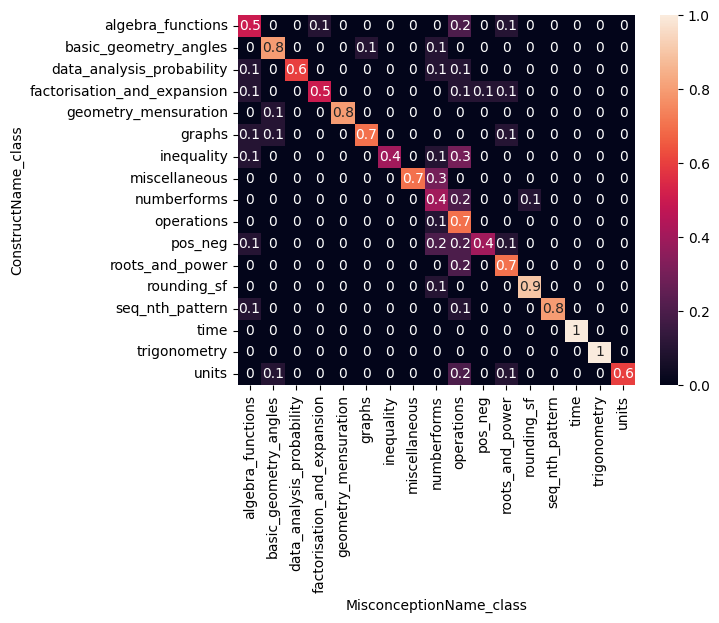

In [68]:
# Comparing Construct vs misconception classifications

train_nafilled_misconceptions = train_nafilled.melt(id_vars=['QuestionId','ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'QuestionText', 'CorrectAnswer'],
                            value_vars=['MisconceptionAId','MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId'],
                           var_name="Misconception",
                           value_name="MisconceptionId").sort_values('QuestionId',ascending=True)

train_nafilled_misconceptions = train_nafilled_misconceptions.merge(train_nafilled[['QuestionId', 'ConstructName_class']],
                                                                   how='left', on='QuestionId')
train_nafilled_misconceptions = train_nafilled_misconceptions[train_nafilled_misconceptions['MisconceptionId'].notnull()].copy()
train_nafilled_misconceptions_mapped = train_nafilled_misconceptions.merge(mis_map,
                                                                   how='left', on='MisconceptionId')
contingency_table = pd.crosstab(train_nafilled_misconceptions_mapped['ConstructName_class'], train_nafilled_misconceptions_mapped['MisconceptionName_class'],
           normalize='index')
sns.heatmap(round(contingency_table, 1), annot=True)

# How many mismatches
n_mismatch = (train_nafilled_misconceptions_mapped['ConstructName_class'] != train_nafilled_misconceptions_mapped['MisconceptionName_class']).sum()
print(f"Number of mismatches: {n_mismatch} / {train_nafilled_misconceptions_mapped.shape[0]}")

pd.crosstab(train_nafilled_misconceptions_mapped['ConstructName_class'], 
            train_nafilled_misconceptions_mapped['MisconceptionName_class'], 
            margins=True)

In [81]:
# Mismatch deeper look into it
mismatches = train_nafilled_misconceptions_mapped[(train_nafilled_misconceptions_mapped['ConstructName_class'] != train_nafilled_misconceptions_mapped['MisconceptionName_class'])].copy()
mismatches = mismatches.sort_values(by=['ConstructName_class', 'QuestionId'])
mismatches.query('ConstructName_class == "pos_neg"')[['QuestionText', 'ConstructName', 'ConstructName_class', "MisconceptionName", 'MisconceptionName_class']].sample(20)


,QuestionText,ConstructName,ConstructName_class,MisconceptionName,MisconceptionName_class
3791,This is a table of values for \( 3 x+2 y=6 \) \nWhat should replace the star? \begin{tabular}{|l|c|c|c|c|c|}\n\hline\( x \) & \( 0 \) & \( 1 \) & \( 2 \) & \( 3 \) & \( 4 \) \\\n\hline\( y \) & \( \color{gold}\bigstar \) & \\\n\hline\n\end{tabular},"Given a positive x value, find a y value in a table of values for lines in the form ax + by = c",pos_neg,"When solving an equation, uses the same operation rather than the inverse.",algebra_functions
1103,\( -\frac{3}{4} \times \star=-1 \) What should replace the star?,Find a negative reciprocal,pos_neg,"When solving a problem that requires an inverse operation (e.g. missing number problems), does the original operation",operations
954,John's flat is on floor \( 4 \).\n\nThe gym is on floor \( -1 \).\n\nHow many floors does John need to go down to get from his flat to the gym? ![A vertical number line from -8 to 7 increasing in 1 digit increments](),Count backwards through zero starting from a positive integer,pos_neg,Does not count end number when counting,numberforms
2646,"Here is a number line: ![A horizontal number-line with 13 vertical, equally spaced, dashes representing the position of numbers. The 1st dash is labelled with ""-6"", the 3rd dash is labelled ""-4"", the 5th dash is labelled ""-2"", the 7th dash is labelled ""0"", the 9th dash is labelled ""2"", the 11th dash is labelled ""4"" and the 13th dash is labelled ""6"" A red arrow, labelled with a question mark is pointing halfway between the 6th and 7th dashes. ]() Which of the following numbers could be indicated by the arrow?",Identify where negative non-integers lie on a number line,pos_neg,Believes a quarter of 2 is 0.25,numberforms
953,John's flat is on floor \( 4 \).\n\nThe gym is on floor \( -1 \).\n\nHow many floors does John need to go down to get from his flat to the gym? ![A vertical number line from -8 to 7 increasing in 1 digit increments](),Count backwards through zero starting from a positive integer,pos_neg,Counts the starting number when counting backwards,numberforms
3757,"![Diagram of a thermometer showing positive and negative temperatures, with an arrow labelled +5 going from -1 up to 4]() Which of the following calculations is represented on the thermometer?",Carry out addition problems involving one negative integer,pos_neg,Believes the number of jumps between two numbers on a numberline represents the sum of those 2 numbers,operations
3752,"""If \( n \) is a positive integer, then \( (2 n-13)^{3} \) is negative""\n\nIs the above statement always true, sometimes true, or never true?",Prove statements involving positive and negative numbers,pos_neg,Believes raising a negative number to an odd power will give a positive answer,roots_and_power
3738,"Here is a number line: ![A horizontal number-line with 13 vertical, equally spaced, dashes representing the position of numbers. The 1st dash is labelled with ""-6"", the 3rd dash is labelled ""-4"", the 5th dash is labelled ""-2"", the 7th dash is labelled ""0"", the 9th dash is labelled ""2"", the 11th dash is labelled ""4"" and the 13th dash is labelled ""6"" A red arrow, labelled with a question mark is pointing halfway between the 3rd and 4th dashes. ]() Which of the following numbers could be indicated by the arrow?",Identify where negative non-integers lie on a number line,pos_neg,Counts on in the wrong direction on a number line,numberforms
784,\( \frac{2}{5} \times \star=-1 \) What should replace the star?,Find a negative reciprocal,pos_neg,"When solving a problem that requires an inverse operation (e.g. missing number problems), does the original operation",operations
45,"![Number line with -12 and -7 marked. Starting at -12, follow an arrow pointing to the right labelled +10. Then there is an arrow labelled b pointing to the left, which ends at -7 on the number line.]() What is the value of \( b \) ?",Carry out missing number subtraction problems i

In [103]:
# Get top categories, and to recategorise 
purity_cutoff = 0.75
high_purity_categories = contingency_table.index[np.diag(round(contingency_table, 3)) >= purity_cutoff]
print("High purity categories: ", high_purity_categories)
train_misconceptions_final = train_nafilled_misconceptions_mapped.copy()
mis_map_final = mis_map.copy()

train_misconceptions_final['ConstructName_class'] = np.where(train_misconceptions_final['ConstructName_class'].isin(high_purity_categories),
                                             train_misconceptions_final['ConstructName_class'],
                                             "all_others")

train_misconceptions_final['MisconceptionName_class'] = np.where(train_misconceptions_final['MisconceptionName_class'].isin(high_purity_categories),
                                             train_misconceptions_final['MisconceptionName_class'],
                                             "all_others")

mis_map_final['MisconceptionName_class'] = np.where(mis_map_final['MisconceptionName_class'].isin(high_purity_categories),
                                             mis_map_final['MisconceptionName_class'],
                                             "all_others")
n_mismatch = (train_misconceptions_final['ConstructName_class'] != train_misconceptions_final['MisconceptionName_class']).sum()
print(f"Number of mismatches: {n_mismatch} / {train_misconceptions_final.shape[0]}")


pd.crosstab(train_misconceptions_final['ConstructName_class'], 
            train_misconceptions_final['MisconceptionName_class'], 
            margins=True)

High purity categories:  Index(['basic_geometry_angles', 'geometry_mensuration', 'rounding_sf',
       'seq_nth_pattern', 'time', 'trigonometry'],
      dtype='object', name='ConstructName_class')
Number of mismatches: 405 / 4370


MisconceptionName_class,all_others,basic_geometry_angles,geometry_mensuration,rounding_sf,seq_nth_pattern,time,trigonometry,All
ConstructName_class,,,,,,,,
all_others,3031,41,14,85,37,5,0,3213
basic_geometry_angles,103,441,11,4,0,0,0,559
geometry_mensuration,19,30,176,0,0,0,0,225
rounding_sf,17,0,0,105,0,0,0,122
seq_nth_pattern,38,0,0,0,133,0,0,171
time,1,0,0,0,0,58,0,59
trigonometry,0,0,0,0,0,0,21,21
All,3209,512,201,194,170,63,21,4370


In [101]:
# Mismatch deeper look into it
mismatches = train_misconceptions_final[(train_misconceptions_final['ConstructName_class'] != train_misconceptions_final['MisconceptionName_class'])].copy()
mismatches = mismatches.sort_values(by=['ConstructName_class', 'QuestionId'])
mismatches.query('ConstructName_class == "seq_nth_pattern"')[['QuestionText', 'ConstructName', 'ConstructName_class', "MisconceptionName", 'MisconceptionName_class']].sample(20)


,QuestionText,ConstructName,ConstructName_class,MisconceptionName,MisconceptionName_class
3444,"Which of the following is the best way to describe this sequence: ![A pattern with 6 terms made of green and red dots. The first term is a green dot, the second a red dot, the third is one red and one green dot. The fourth term is made of one green and two red dots. The fifth term is made from two green dots and three red dots. The sixth term is made of five red dots and three green dots. ]()",Recognise a Fibonacci sequence expressed as a pattern,seq_nth_pattern,Does not understand the term quadratic,all_others
819,Which of the following is the most appropriate word to describe \( 3 g \) in this: \( 6-3 g \),Recognise and name a term,seq_nth_pattern,Confuses a term with a variable,all_others
1932,"Amelie is counting backwards in steps of \( 4 \).\nShe starts at the number \( 24,993 \)\nwhat is the next number she will say?",Count backwards in steps of of something other than one,seq_nth_pattern,"Counts on by 1, when asked to count forward/backwards in a step other than 1",all_others
2869,Which of the following is the most appropriate word to describe \( y^{2} \) in this: \( y^{2}-9 \),Recognise and name a term,seq_nth_pattern,Confuses a term with a variable,all_others
4105,![Square then subtract \( 2 \)]() The first three terms of which sequence below is produced by this term-to-term rule?,"Given a description of an ascending sequence using quadratics in words, write some terms of that sequence",seq_nth_pattern,"Believes term to term rule is applied to position number, not previous term",all_others
3948,The \( 1^{\text {st }} \) term in a linear sequence is \( 8 \). The \( 4^{\text {th }} \) term of the sequence is \( 41 \). What is the \( 8^{\text {th }} \) term of the sequence?,Write a missing term of an ascending integer linear sequence,seq_nth_pattern,Believes you multiply the constant difference by the term number to get the term value,all_others
4055,"\[\n-1,4,11,20,31, \ldots\n\]\n\nWhen calculating the nth-term rule of this sequence, what should replace the square? nth-term rule:\n\(\nn^{2}+2 n \) \(\square\)\n",Find the nth term rule for ascending quadratic sequences in the form x² + bx + c,seq_nth_pattern,Believes subtraction is commutative,all_others
2956,"\( \frac{7}{6}, \frac{4}{3}, \frac{3}{2}, \frac{5}{3}, \ldots \) When calculating the nth-term rule of this sequence, what should replace the star? ![Text: ""nth-term rule:"" followed by a star, n and a purple rectangle. ]()",Find the nth term rule for an ascending fractional linear sequence,seq_nth_pattern,"When subtracting fractions, subtracts the numerators and denominators",all_others
2870,Which of the following is the most appropriate word to describe \( y^{2} \) in this: \( y^{2}-9 \),Recognise and name a term,seq_nth_pattern,Confuses an expression with a term,all_others
222,"Tom and Katie are discussing quadratic sequences.\n\nTom says this is a quadratic sequence: \( 24,15,8,3,0 \ldots \)\n\nKatie says this is a quadratic sequence: \( 124,63,26,7,3,0, \ldots \)\n\nWho is correct?",Recognise when a descending sequence is quadratic,seq_nth_pattern,Does not understand the term quadratic,all_others
